This analyses the fourroom env with random starts, fixed goal.

In [16]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from experiments.feat_att_minigrid.n_room_env import FourRoomChainEnv
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from stable_baselines3 import PPO
from cnn import MinigridFeaturesExtractor
from stable_baselines3.common.utils import obs_as_tensor
import glfw

In [58]:
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 2e6,
    "env_name": "Four-Room-Chain",
    "feat_dim":12,
    "random_starts": False,
}
# load agent
# model = PPO.load("/Users/kevinroice/Documents/research/discovery/models/8qilkcik/model") # 32 dim feats
# model = PPO.load("/Users/kevinroice/Documents/research/discovery/models/f8e0x616/model") # 16 dim feats
model = PPO.load("/Users/kevinroice/Documents/research/discovery/models/w75lcl94/model") # 12 dim feats
def make_env():
    env = FourRoomChainEnv(render_mode="rgb_array", random_starts=config["random_starts"])
    env = FullyObsWrapper(env)
    env = ImgObsWrapper(env)
    env = Monitor(env)
    return env

def pre_process_obs(obs, model):
    obs = np.transpose(obs, (0,3,1,2)) # bring colour channel to front
    return obs_as_tensor(obs, model.policy.device)

def get_hallway_obs(env, see_obs=False):
    # # Vector Action Encoding:
    # 0 = left
    # 1 = right
    # 2 = forward

    obs = env.reset() # initial obs
    obs_list = []
    
    # move to the hallway
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([0])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([0])
    obs, _, _, _ = env.step([0])
    # obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    # obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    # obs_list.append(obs)

    # move to the next hallway
    obs, _, _, _ = env.step([0])
    obs, _, _, _ = env.step([0])
    for i in range(7):
        obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([0])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([0])
    obs, _, _, _ = env.step([0])
    # obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    # obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    # obs_list.append(obs)

    # move to the next hallway
    obs, _, _, _ = env.step([0])
    obs, _, _, _ = env.step([0])
    for i in range(7):
        obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([0])    
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)
    # obs, _, _, _ = env.step([0])
    # obs, _, _, _ = env.step([0])
    # # obs_list.append(obs)
    # obs, _, _, _ = env.step([2])
    # # obs_list.append(obs)
    # obs, _, _, _ = env.step([2])
    # # obs_list.append(obs)
    
    if see_obs:
        img = env.render()
        plt.figure()
        plt.imshow(np.concatenate([img], 1)) # shows the full environment
        plt.savefig("../../plots/feature_activations/minigrid_4RoomChain/hallway_33.png", dpi=300)
    
    return obs_list

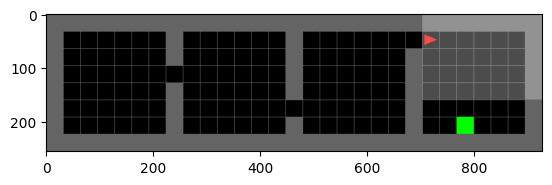

In [59]:
env = DummyVecEnv([make_env])
obs = env.reset()
obs_list = get_hallway_obs(env, see_obs=True)

In [8]:
max_feat_list = []
feature_activations = []

with torch.no_grad():
    for obs in obs_list:
        obs = pre_process_obs(obs, model)
        x = model.policy.extract_features(obs)
        max_feat_list.append(torch.argmax(x).item())
        feature_activations.append(x.reshape(1, -1))

feature_activations = torch.cat(feature_activations, dim=0)

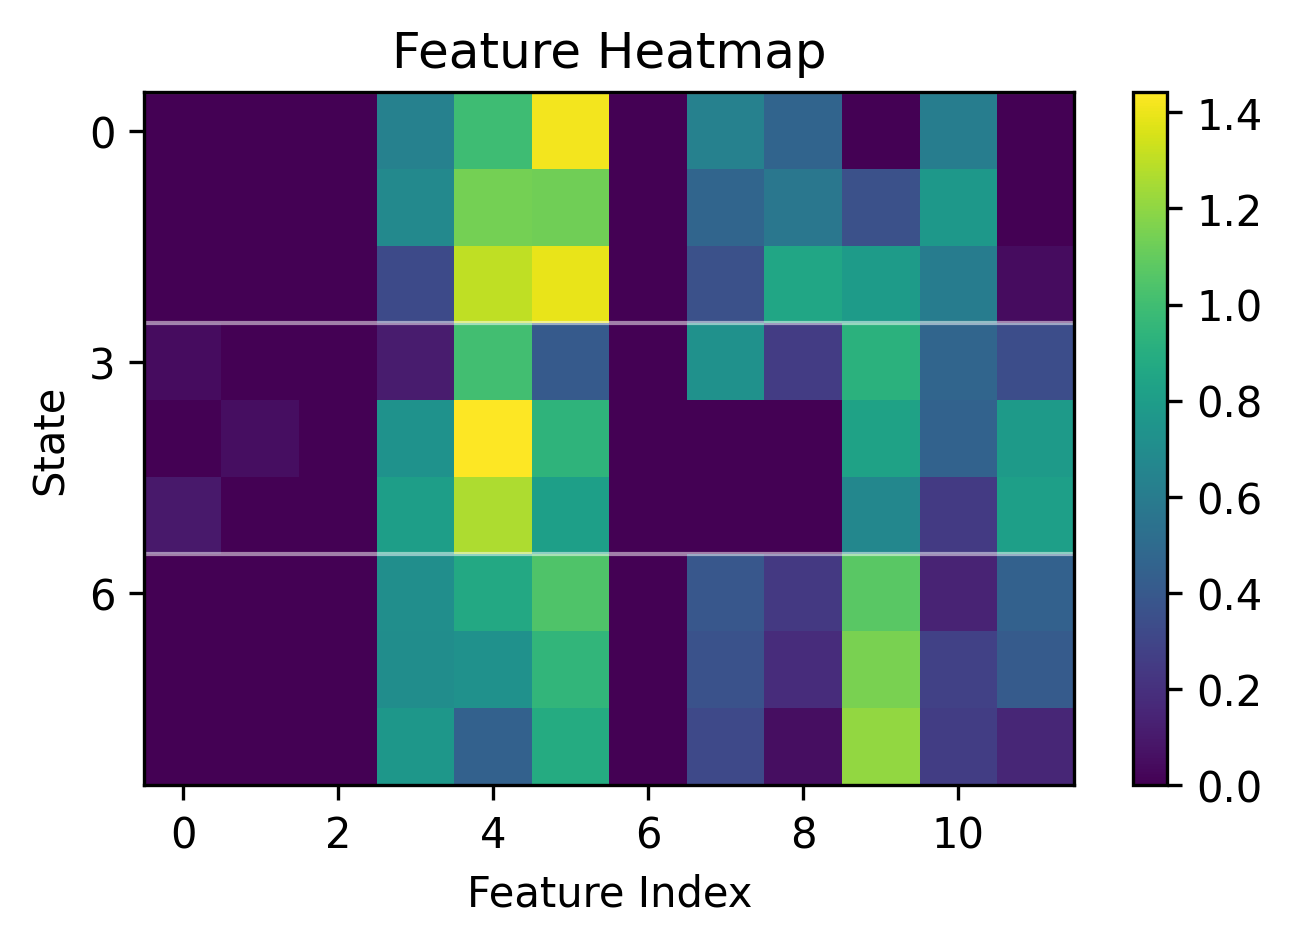

In [62]:
plt.figure(figsize=(5, 3), dpi=300)  # Adjust the figure size as needed
plt.imshow(feature_activations, cmap='viridis', aspect='auto')
# y_tick_positions = [i * 56 for i in range(785 // 56)] # 16 by 16
y_tick_positions = [i * 3 for i in range(9 // 3)]
plt.yticks(y_tick_positions)
for y in y_tick_positions:
    plt.axhline(y=y-0.5, linewidth=1, color='white', alpha=0.5)
plt.colorbar()
plt.xlabel('Feature Index')
plt.ylabel('State')
plt.title('Feature Heatmap')
plt.savefig('../../plots/feature_activations/minigrid_4RoomChain/feature_heatmap.pdf', bbox_inches='tight')